# Privacy Policies Through Time

*An exploration of how privacy policies have evolved and reacted to different legislative and media events throughout the years.*



In [1]:
# project imports
import env
from build_master_index import MASTER_CSV, PROBLEM_COMPANIES
from wayback_search import POLICY_DIR


# python & package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os


# plot things
%matplotlib inline
# autoreload modules
%load_ext autoreload
%autoreload 2

## Dataset

This project has put together a historical dataset containing all of the privacy policy revisions of various companies.

In [2]:
df = pd.read_csv(MASTER_CSV)
df.policy_date = pd.to_datetime(df.policy_date)
df.company = pd.Categorical(df.company)
df['company_id'] = df.company.cat.codes
df.head()

,company,policy_date,policy_url,policy_path,company_id
0,1password,2017-02-02,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-02-02.txt,0
1,1password,2017-03-16,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-03-16.txt,0
2,1password,2017-08-02,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-08-02.txt,0
3,1password,2018-03-15,https://1password.com/legal/privacy/privacy-20...,1password/1password-2018-03-15.txt,0
4,1password,2018-04-04,https://1password.com/legal/privacy/privacy-20...,1password/1password-2018-04-04.txt,0


In [3]:
# check for any policy paths that do not exist
df[~pd.Series([os.path.exists(os.path.join(POLICY_DIR, x)) for x in df.policy_path])]

,company,policy_date,policy_url,policy_path,company_id


In [4]:
print(len(df.company.unique()))
print(len(df.policy_path.unique()))
print(len(df))

20
277
291


In [5]:
# sometimes duplicate csv rows appear because of overlap in the
# dates of two configurations; they are the same policy most likely
# so we just drop the duplicate
df = df[~df.duplicated('policy_path')]
len(df)

277

In [6]:
# some companies proved more difficult than others when gathering
# privacy policies, so we drop them here (the policies are left
# as part of the original dataset because they are valid policies,
# but we do not have all the revisions)
df = df[~df.company.str.contains('|'.join(PROBLEM_COMPANIES))]
len(df)

249

In [7]:
print(len(df.company.unique()))
df.company.unique()

17


[1password, amazon, apple, cisco, facebook, ..., target, twitter, uber, walmart, washingtonpost]
Length: 17
Categories (17, object): [1password, amazon, apple, cisco, ..., twitter, uber, walmart, washingtonpost]

In [8]:
print(min(df.policy_date))
print(max(df.policy_date))

1999-06-09 00:00:00
2019-11-08 00:00:00


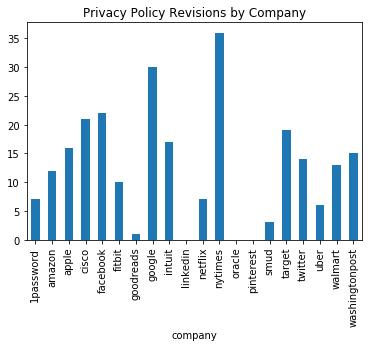

In [9]:
grouped = df.groupby('company').policy_path.count()
grouped.plot.bar(title='Privacy Policy Revisions by Company')

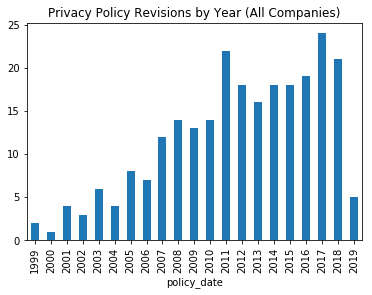

In [10]:
grouped = df.groupby([df.policy_date.dt.year]).policy_path.count()
grouped.plot.bar(title='Privacy Policy Revisions by Year (All Companies)')

In [11]:
def get_policy_text(row):
    """
    Creates a pd.Series of full text from policies

    Args:
        row: pd.Series, row of policy index dataframe
        
    Returns:
        pd.Series, a new row with 'policy_text' col
    """
    page = ''
    with open(os.path.join(POLICY_DIR, row['policy_path']), 'r', encoding='utf-8') as f:
        page = f.read()
    row['policy_text'] = page
    return row

In [12]:
df = df.apply(get_policy_text, axis=1)
df.head()

,company,policy_date,policy_url,policy_path,company_id,policy_text
0,1password,2017-02-02,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-02-02.txt,0,\nMenuHomeTourFamiliesBusinessPricingSecurityS...
1,1password,2017-03-16,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-03-16.txt,0,\nMenuHomeTourFamiliesBusinessPricingSecurityS...
2,1password,2017-08-02,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-08-02.txt,0,\nMenuHomeTourFamiliesBusinessPricingSecurityS...
3,1password,2018-03-15,https://1password.com/legal/privacy/privacy-20...,1password/1password-2018-03-15.txt,0,\nMenuHomeTourFamiliesBusinessPricingSecurityS...
4,1password,2018-04-04,https://1password.com/legal/privacy/privacy-20...,1password/1password-2018-04-04.txt,0,\nMenuHomeTourFamiliesBusinessPricingSecurityS...


## Children's Online Privacy Protection Act (COPPA)

From [Wikipedia](https://en.wikipedia.org/wiki/Children%27s_Online_Privacy_Protection_Act):

   "The act, effective April 21, 2000, applies to the online collection of personal information by persons or entities under
   U.S. jurisdiction about children under 13 years of age or children with disabilities. **It details what a website
   operator must include in a privacy policy**, when and how to seek verifiable consent from a parent or guardian, and what
   responsibilities an operator has to protect children's privacy and safety online including restrictions on the marketing
   of those under 13."

Based on the above, we should expect to see privacy policies mention their practices with children's data starting in April of 2000.

In [13]:
coppa = df.copy()
# https://chrisalbon.com/python/data_wrangling/pandas_create_column_using_conditional/
coppa['mentions_children'] = np.where(coppa.policy_text.str.contains('children|Children|CHILDREN'), 1, 0)
#coppa = coppa[['company', 'policy_date', 'mentions_children']]
print('{} / {} policies mention children'.format(len(coppa[coppa.mentions_children == 1]), len(coppa)))

188 / 249 policies mention children


In [14]:
#coppa.policy_date = coppa.policy_date.astype(str).str.replace('-', '').astype(int)
#coppa['policy_date_plt'] = mdates.date2num(coppa.policy_date)
coppa.head()

,company,policy_date,policy_url,policy_path,company_id,policy_text,mentions_children
0,1password,2017-02-02,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-02-02.txt,0,\nMenuHomeTourFamiliesBusinessPricingSecurityS...,1
1,1password,2017-03-16,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-03-16.txt,0,\nMenuHomeTourFamiliesBusinessPricingSecurityS...,1
2,1password,2017-08-02,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-08-02.txt,0,\nMenuHomeTourFamiliesBusinessPricingSecurityS...,1
3,1password,2018-03-15,https://1password.com/legal/privacy/privacy-20...,1password/1password-2018-03-15.txt,0,\nMenuHomeTourFamiliesBusinessPricingSecurityS...,0
4,1password,2018-04-04,https://1password.com/legal/privacy/privacy-20...,1password/1password-2018-04-04.txt,0,\nMenuHomeTourFamiliesBusinessPricingSecurityS...,0


In [15]:
result = coppa.pivot(index='company', columns='policy_date', values='mentions_children')
result.head()

policy_date,1999-06-09 00:00:00,1999-09-20 00:00:00,2000-10-31 00:00:00,2001-01-04 00:00:00,2001-05-04 00:00:00,2001-06-04 00:00:00,2001-11-06 00:00:00,2002-06-09 00:00:00,2002-08-27 00:00:00,2002-10-03 00:00:00,...,2018-05-25 00:00:00,2018-09-18 00:00:00,2018-10-26 00:00:00,2018-12-10 00:00:00,2018-12-17 00:00:00,2019-01-22 00:00:00,2019-02-01 00:00:00,2019-04-23 00:00:00,2019-05-21 00:00:00,2019-11-08 00:00:00
company,,,,,,,,,,,,,,,,,,,,,
1password,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amazon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apple,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cisco,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facebook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
for i1, row in result.transpose().iteritems():
    last = np.nan
    for i2, value in row.iteritems():
        if np.isnan(value):
            # set it equal to last value
            value = last
        result.at[i1, i2] = value
        last = value
        
result.head()

policy_date,1999-06-09 00:00:00,1999-09-20 00:00:00,2000-10-31 00:00:00,2001-01-04 00:00:00,2001-05-04 00:00:00,2001-06-04 00:00:00,2001-11-06 00:00:00,2002-06-09 00:00:00,2002-08-27 00:00:00,2002-10-03 00:00:00,...,2018-05-25 00:00:00,2018-09-18 00:00:00,2018-10-26 00:00:00,2018-12-10 00:00:00,2018-12-17 00:00:00,2019-01-22 00:00:00,2019-02-01 00:00:00,2019-04-23 00:00:00,2019-05-21 00:00:00,2019-11-08 00:00:00
company,,,,,,,,,,,,,,,,,,,,,
1password,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
amazon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
apple,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
cisco,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
facebook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


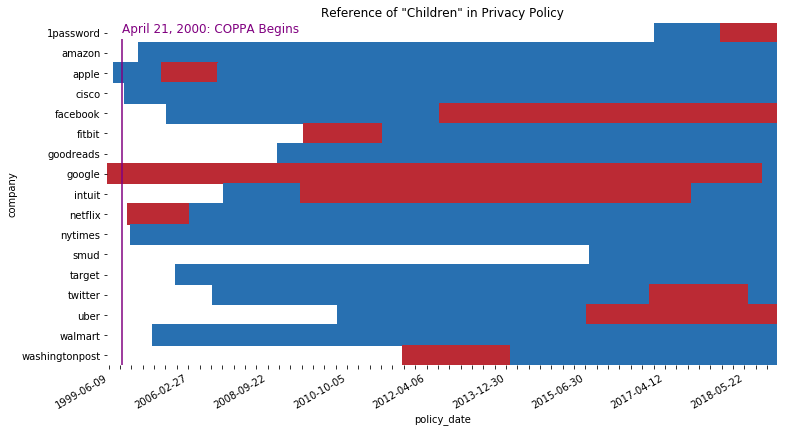

In [18]:
# init plot
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title('Reference of "Children" in Privacy Policy')

# prepare mask for null values when a company does not yet have a published privacy policy
mask = np.zeros_like(result)
mask[np.isnan(result)] = True

# do plot
# https://stackoverflow.com/questions/37790429/seaborn-heatmap-using-pandas-dataframe
sp = sns.heatmap(result, ax=ax, fmt="g", cmap=sns.color_palette("RdBu", 7), mask=mask, cbar=False)

# add vertical line for coppa
ax.vlines(5, .8, 20, color='purple')
plt.text(5, 0.5, 'April 21, 2000: COPPA Begins', color='purple', fontsize=12)

# format and space xticks
xlocs, xlabels = plt.xticks()
#print(list(zip(xlocs, xlabels)))
for i, x in enumerate(xlabels):
    text = ''
    if i % 7 == 0:
        text = x._text[:x._text.find('T')]
    xlabels[i]._text = text
_ = ax.set_xticklabels(xlabels)    
fig.autofmt_xdate()

## Google

In [ ]:
google = df[df.company == 'google']
google.head()

In [ ]:
google = google.apply(get_policy_text, axis=1)

In [ ]:
google['policy_text_len'] = google.policy_text.str.len()

In [ ]:
google[['policy_date', 'policy_text_len']].plot.bar('policy_date', title="Google's Privacy Policy Length By Revision")